uint8
Weigth= 456
Heigth= 320


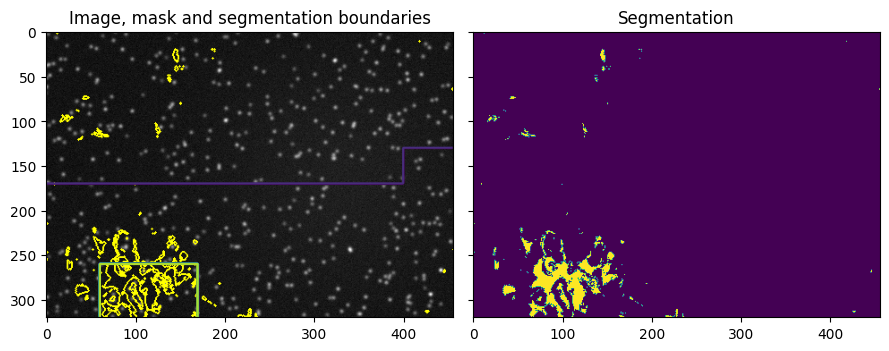

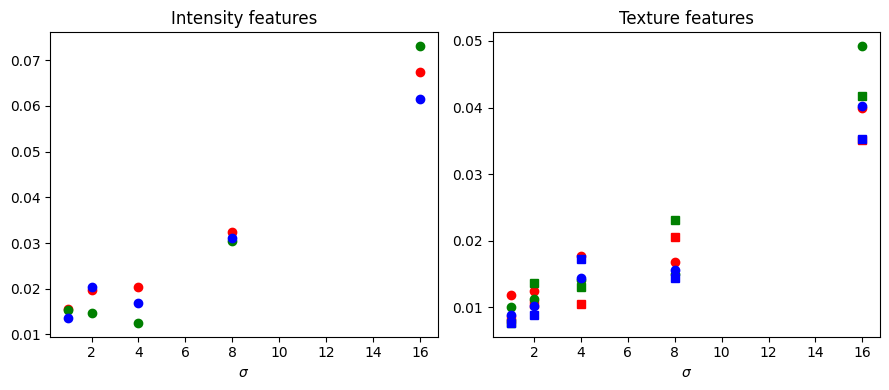

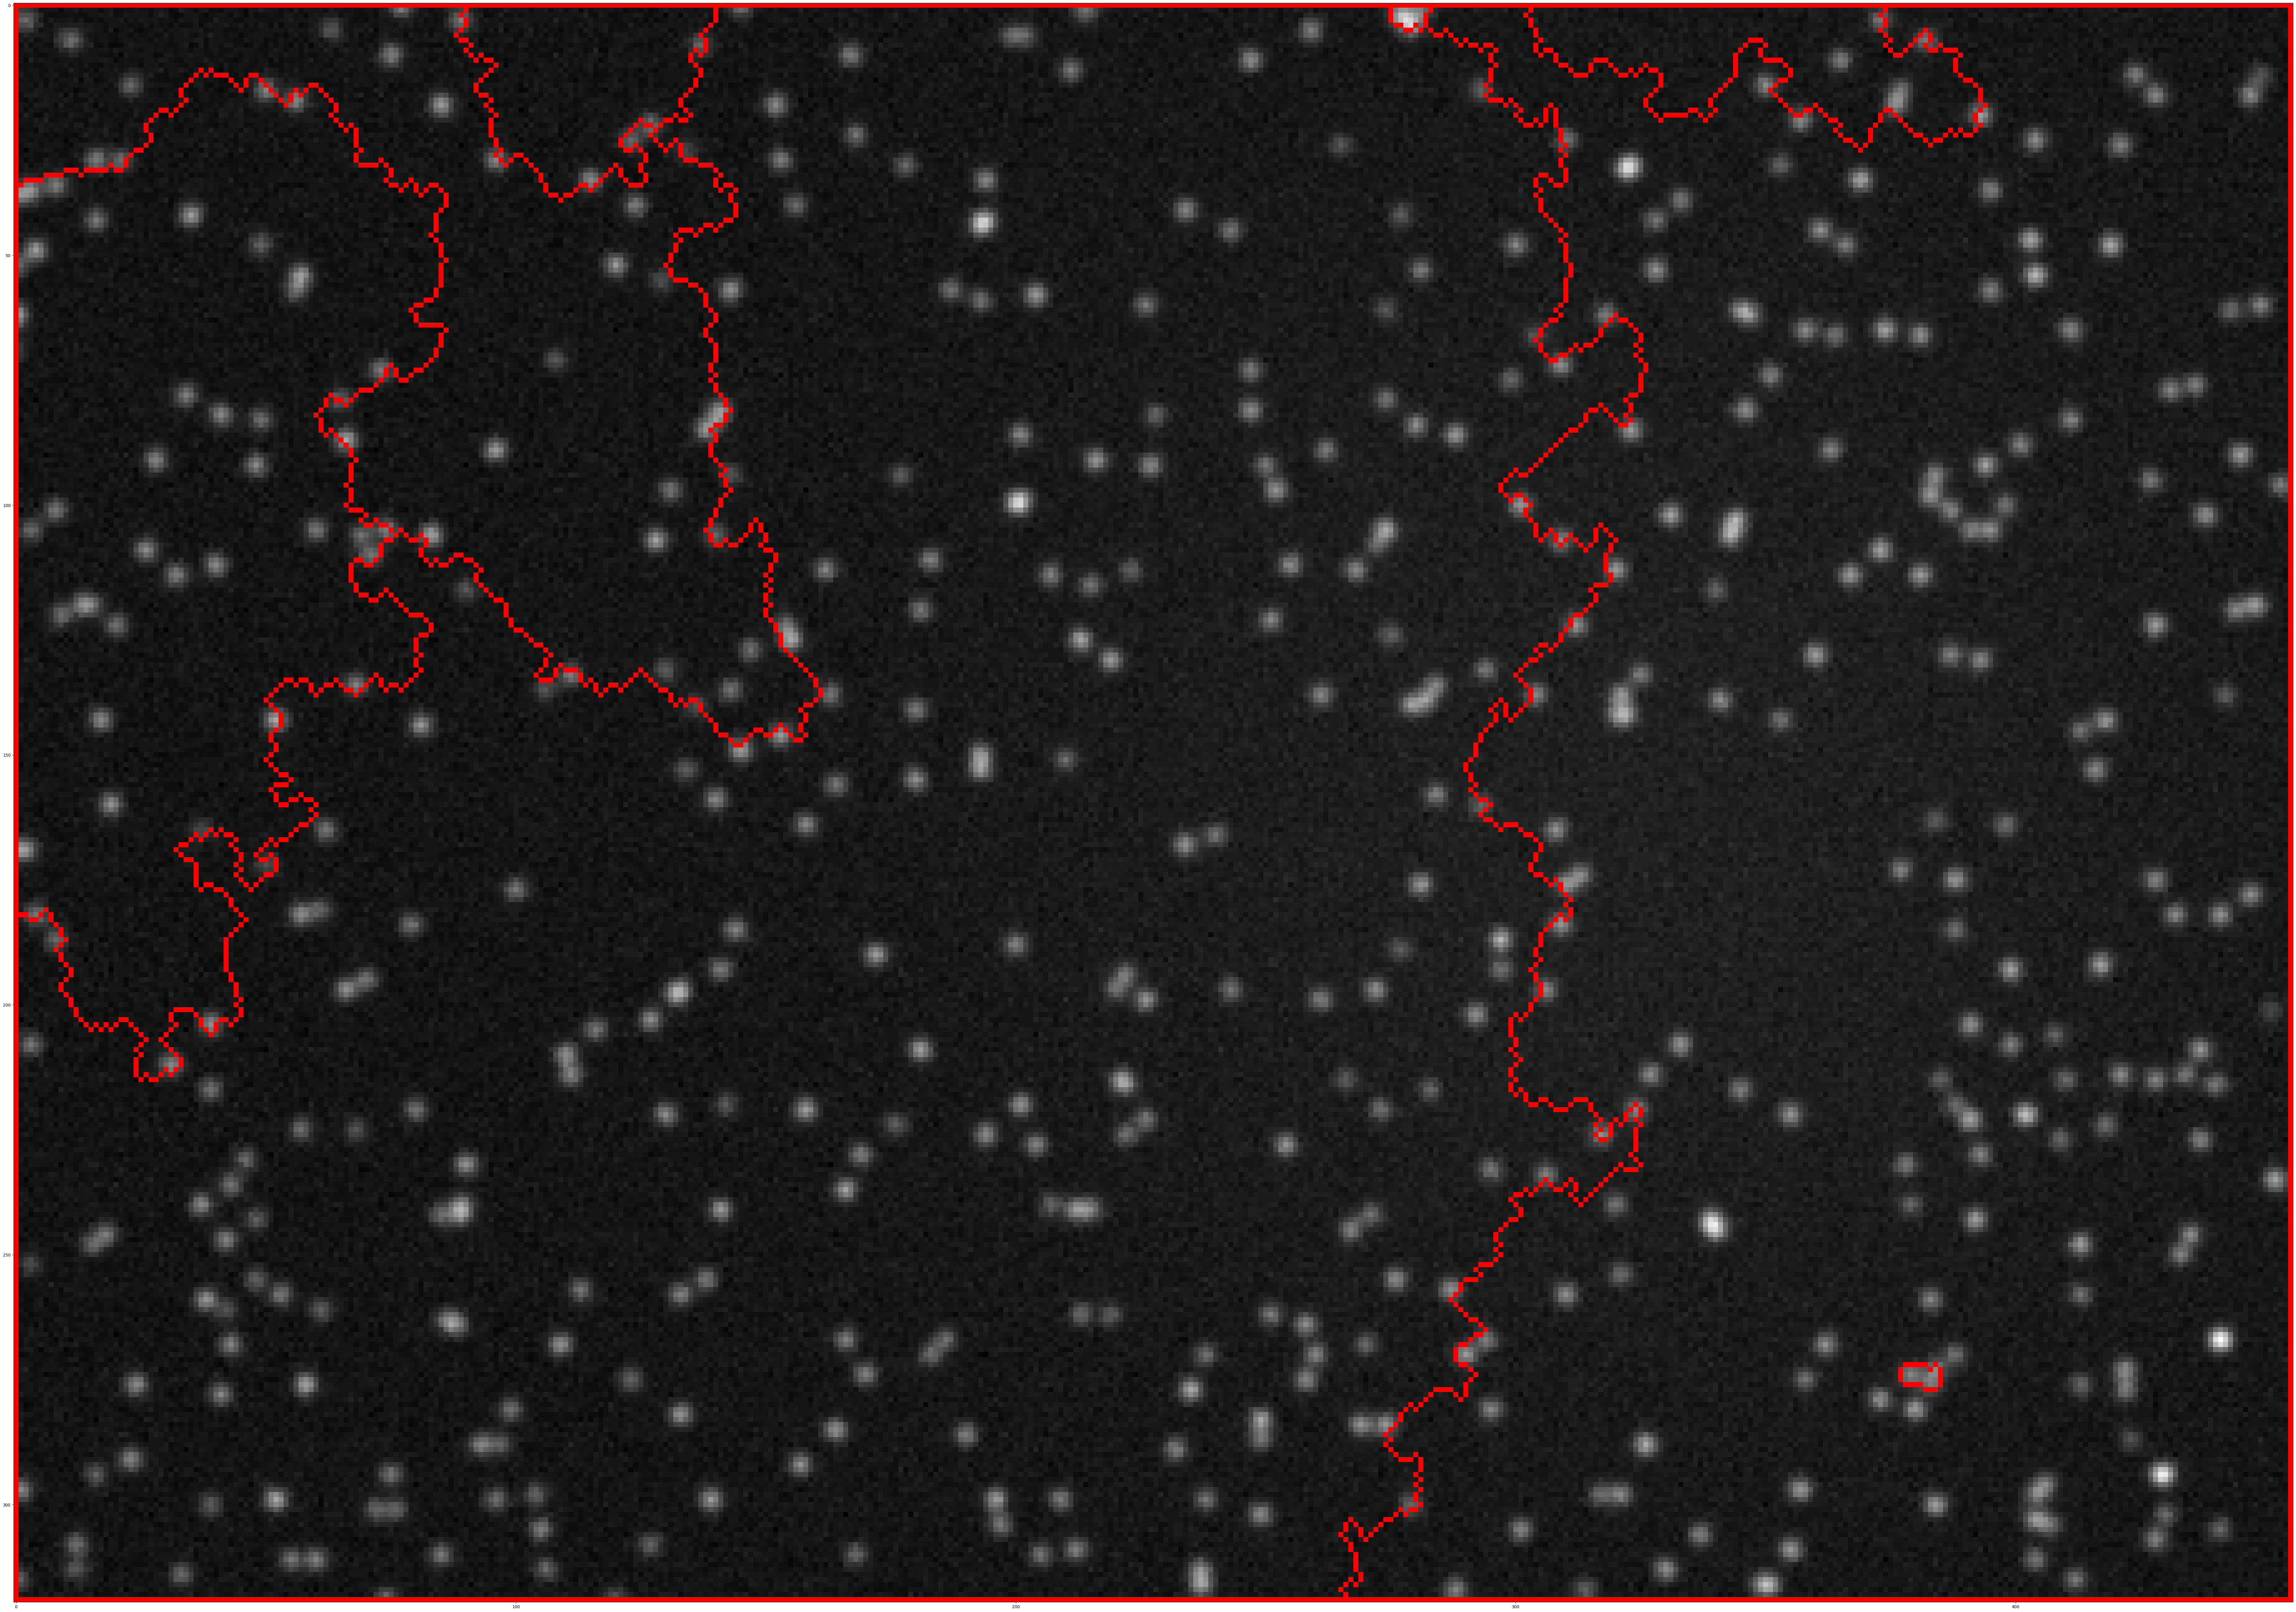

In [5]:
import cv2
def pngreader(filepath):
    image=cv2.imread(filepath,-1)
    #print(image.shape)
    print(image.dtype)
    h, w = image.shape[:2]
    print(f'Weigth= {w}')
    print(f'Heigth= {h}')
    assert image  is not None, "file could not be read, check with os.path.exists()"
    return image

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
def main():
    image=pngreader("C:/Users/evgen/Downloads/2712_1.png")
    full_img=image
    img = full_img[:900, :900]

    # Build an array of labels for training the segmentation.
    # Here we use rectangles but visualization libraries such as plotly
    # (and napari?) can be used to draw a mask on the image.
    training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
    training_labels[:130] = 1
    training_labels[:170, :400] = 1
    training_labels[600:900, 200:650] = 2
    training_labels[330:430, 210:320] = 3
    training_labels[260:340, 60:170] = 4
    training_labels[150:200, 720:860] = 4

    sigma_min = 1
    sigma_max = 16
    features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
    features = features_func(img)
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
    clf = future.fit_segmenter(training_labels, features, clf)
    result = future.predict_segmenter(features, clf)

    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].contour(training_labels)
    ax[0].set_title('Image, mask and segmentation boundaries')
    ax[1].imshow(result)
    ax[1].set_title('Segmentation')
    fig.tight_layout()

    ##############################################################################
    # Feature importance
    # ------------------
    #
    # We inspect below the importance of the different features, as computed by
    # scikit-learn. Intensity features have a much higher importance than texture
    # features. It can be tempting to use this information to reduce the number of
    # features given to the classifier, in order to reduce the computing time.
    # However, this can lead to overfitting and a degraded result at the boundary
    # between regions.

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    l = len(clf.feature_importances_)
    feature_importance = (
        clf.feature_importances_[:l//3],
        clf.feature_importances_[l//3:2*l//3],
        clf.feature_importances_[2*l//3:])
    sigmas = np.logspace(
        np.log2(sigma_min), np.log2(sigma_max),
        num=int(np.log2(sigma_max) - np.log2(sigma_min) + 1),
        base=2, endpoint=True)
    for ch, color in zip(range(3), ['r', 'g', 'b']):
        ax[0].plot(sigmas, feature_importance[ch][::3], 'o', color=color)
        ax[0].set_title("Intensity features")
        ax[0].set_xlabel("$\\sigma$")
    for ch, color in zip(range(3), ['r', 'g', 'b']):
        ax[1].plot(sigmas, feature_importance[ch][1::3], 'o', color=color)
        ax[1].plot(sigmas, feature_importance[ch][2::3], 's', color=color)
        ax[1].set_title("Texture features")
        ax[1].set_xlabel("$\\sigma$")

    fig.tight_layout()

    ##############################################################################
    # Fitting new images
    # ------------------
    #
    # If you have several images of similar objects acquired in similar conditions,
    # you can use the classifier trained with `fit_segmenter` to segment other
    # images. In the example below we just use a different part of the image.
    img_new = full_img[:700, 900:]

    #features_new = features_func(img_new)
    #result_new = future.predict_segmenter(features_new, clf)
    #fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 4))
    #ax[0].imshow(segmentation.mark_boundaries(img_new, result_new, mode='thick'))
    #ax[0].set_title('Image')
    #ax[1].imshow(result_new)
    #ax[1].set_title('Segmentation')
    #fig.tight_layout()
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(image,markers)
    image[markers == -1] = [255,0,0]

    plt.figure(figsize = [100, 100])
    plt.imshow(image)

    plt.show()


if __name__ == '__main__':
    main()




